# An intro to PyTorch

At its core, PyTorch provides two main features:

- An n-dimensional Tensor, similar to numpy but can run on GPUs
- Automatic differentiation for building and training neural networks

We will use a fully-connected ReLU network as our running example. The network will have a single hidden layer, and will be trained with gradient descent to fit random data by minimizing the Euclidean distance between the network output and the true output.

**Scheme for the Architecture**

```
                   INPUT (x)                       LABELS (y)
                 [ N x D_in ]                    [ N x D_out ]
        +--------------------------+                   |
         \        Linear          /                    |
          \       Layer          /                     |
           +--------------------+                      |
                 [ N x H ]                             |
           +--------------------+                      |
           |       ReLu         |                      |
           +--------------------+                      |
                 [ N x H ]                             |
           +--------------------+                      |
          /       Linear         \                     |
         /        Layer           \                    |
        +--------------------------+                   |
               [ N x D_out ]                           |
             PREDICTION (y_pred)                       |
                     |                                 |
                     +----------->(loss_fn)<-----------+
                                      |
                                    LOSS

```


We will first implement it in numpy and then take a look at all the features in PyTorch which make its implementation easier and more efficient.

In the end you will be prompted to create a variation of this architecture and your own and train it!

<a name="outline"></a>
## Outline
- [1) Warm-up: numpy](#1)
- [2) PyTorch: Tensors](#2)
- [3) PyTorch: Autograd](#3)
- [4) PyTorch: nn](#4)
- [5) PyTorch: optim](#5)
- [6) Custom nn Modules](#6)
- [7) Control Flow + Weight Sharing [Exercise]](#7)

## 1) Warm-up: numpy
<a name="1"></a>
[back to Outline](#outline)

Before introducing PyTorch, we will first implement the neural network using numpy.

Numpy provides an n-dimensional array object, and many functions for manipulating these arrays.

Numpy is a generic framework for scientific computing; it does not know anything about computation graphs, or deep learning, or gradients.

However we can easily use numpy to fit a two-layer network to random data by manually implementing the forward and backward passes through the network using numpy operations:

In [2]:
import numpy as np
import pandas as pd

loss_df = pd.DataFrame(index=list(range(500)), columns=["loss"])

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random input and output data
x = np.random.randn(N, D_in)
y = np.random.randn(N, D_out)

# Randomly initialize weights
w1 = np.random.randn(D_in, H)
w2 = np.random.randn(H, D_out)

learning_rate = 1e-6
for epoch in range(500):
    # Forward pass: compute predicted y
    h = x.dot(w1)
    h_relu = np.maximum(h, 0)
    y_pred = h_relu.dot(w2)

    # Compute and store loss
    loss = np.square(y_pred - y).sum()
    loss_df.at[epoch, "loss"] = loss

    # Backprop to compute gradients of w1 and w2 with respect to loss
    grad_y_pred = 2.0 * (y_pred - y)
    grad_w2 = h_relu.T.dot(grad_y_pred)
    grad_h_relu = grad_y_pred.dot(w2.T)
    grad_h = grad_h_relu.copy()
    grad_h[h < 0] = 0
    grad_w1 = x.T.dot(grad_h)

    # Update weights
    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2

Quick reminder: we can use `pandas` to quickly visualize the values of the loss during training.

            loss
1    2.99389e+07
2    3.01373e+07
3    2.92171e+07
497  1.02335e-07
498  9.69849e-08
499  9.19156e-08


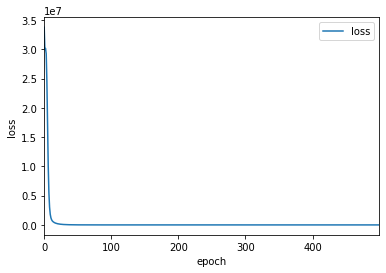

In [3]:
# print first three and last three values of the loss
print(loss_df.iloc[[1,2,3, -3,-2,-1]])

xs = loss_df.plot()
_ = xs.set_ylabel("loss")
_ = xs.set_xlabel("epoch")

## 2) PyTorch: Tensors
<a name="2"></a>
[back to Outline](#outline)

As you saw numpy is a great framework and we can implement a neural network with it... but it cannot utilize **GPUs** to accelerate its numerical computations. For modern deep neural networks, GPUs often provide speedups of **50x or greater**, so unfortunately numpy won't be enough for modern deep learning.

Here we introduce the most fundamental PyTorch concept: the **Tensor**.

### Creating Tensors

A PyTorch Tensor is conceptually identical to a numpy array: a Tensor is an n-dimensional array, and PyTorch provides many functions for operating on these Tensors.

_Any computation you might want to perform with numpy can also be accomplished with PyTorch Tensors_. You should think of them as a generic tool for scientific computing.

In [1]:
import torch

# Here is a 5x3 matrix, uninitialized:
# it does not contain definite known values before it is used

x = torch.empty(5, 3)
print(x)

tensor([[0.0000e+00, 1.4013e-45, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.1614e-41, 0.0000e+00, 2.2369e+08],
        [0.0000e+00, 0.0000e+00, 0.0000e+00]])


In [5]:
# Construct a randomly initialized matrix

x = torch.rand(5, 3)
print(x)

tensor([[0.3543, 0.5612, 0.6486],
        [0.4240, 0.6980, 0.9975],
        [0.6176, 0.1099, 0.2249],
        [0.5379, 0.4828, 0.5170],
        [0.3960, 0.6877, 0.7253]])


In [6]:
# Construct a matrix filled zeros and of dtype long:

x = torch.zeros(5, 3, dtype=torch.long)
print(x)

tensor([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]])


In [7]:
# Create an array of all ones
b = torch.ones((1,2))   
print(b)

tensor([[1., 1.]])


In [8]:
# Construct a tensor directly from data:

x = torch.tensor([5.5, 3])
print(x)

tensor([5.5000, 3.0000])


In [9]:
# you can use *_like(t) to create tensors of zeros/ones/random with the same shape of t

b = torch.ones_like(x)
print(x)
print(b)

tensor([5.5000, 3.0000])
tensor([1., 1.])


In [10]:
# torch tensors can be converted into numpy arrays
# and keep them connected

x = torch.zeros(3,2)
print(type(x)); print(x)

y = x.numpy()
print(type(y)); print(y)


print()

x += 1
print(type(x)); print(x)
print(type(y)); print(y)

<class 'torch.Tensor'>
tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])
<class 'numpy.ndarray'>
[[0. 0.]
 [0. 0.]
 [0. 0.]]

<class 'torch.Tensor'>
tensor([[1., 1.],
        [1., 1.],
        [1., 1.]])
<class 'numpy.ndarray'>
[[1. 1.]
 [1. 1.]
 [1. 1.]]


In [11]:
# the same can be done the other way

z = torch.from_numpy(y)
print(z)
print()

y+=1

print(y)
print(z)

tensor([[1., 1.],
        [1., 1.],
        [1., 1.]])

[[2. 2.]
 [2. 2.]
 [2. 2.]]
tensor([[2., 2.],
        [2., 2.],
        [2., 2.]])


In [12]:
# each tensor has a .size() (or .shape) and can be reshaped

x = torch.randn(4, 4)
y = x.view(16)
z = x.view(-1, 8)  # the size -1 is inferred from other dimensions

print(x)
print(x.size(), "\n")

print()

print(y)
print(y.size(), "\n")

print()

print(z)
print(z.size())
print(z.shape, "\n")

tensor([[ 0.1417,  0.4522, -0.2078,  0.3465],
        [ 1.1520,  0.3241,  1.5589, -0.3883],
        [-2.8291, -0.2369, -0.4588,  0.6151],
        [-0.6376,  1.7853,  0.7089, -1.4544]])
torch.Size([4, 4]) 


tensor([ 0.1417,  0.4522, -0.2078,  0.3465,  1.1520,  0.3241,  1.5589, -0.3883,
        -2.8291, -0.2369, -0.4588,  0.6151, -0.6376,  1.7853,  0.7089, -1.4544])
torch.Size([16]) 


tensor([[ 0.1417,  0.4522, -0.2078,  0.3465,  1.1520,  0.3241,  1.5589, -0.3883],
        [-2.8291, -0.2369, -0.4588,  0.6151, -0.6376,  1.7853,  0.7089, -1.4544]])
torch.Size([2, 8])
torch.Size([2, 8]) 



### Tensors on the GPU

However unlike numpy, PyTorch Tensors can utilize GPUs to accelerate their numeric computations. To run a PyTorch Tensor on GPU, you use the device argument when constructing a Tensor to place the Tensor on a GPU.

Tensors can be moved onto any device using the `.to` method, or created directly onto any device using `device`.


In [13]:
# We will use torch.device objects to move tensors in and out of GPU
if torch.cuda.is_available():
    print("Cuda available")
    device = torch.device("cuda")          # a CUDA device object
    y = torch.ones_like(x, device=device)  # directly create a tensor on GPU
    x = x.to(device)                       # or just use strings .to("cuda")
    z = x + y
    print(z)
    print(z.to("cpu", torch.double))       # .to can also change dtype together!
else:
    print("Cuda not available")

Cuda not available


Here we use PyTorch Tensors to fit a two-layer network to random data. Like the numpy example above we manually implement the forward and backward passes through the network, using operations on PyTorch Tensors:

            loss
1    2.81198e+07
2    2.48444e+07
3    2.03242e+07
497  3.09069e-05
498  3.05787e-05
499  3.01044e-05


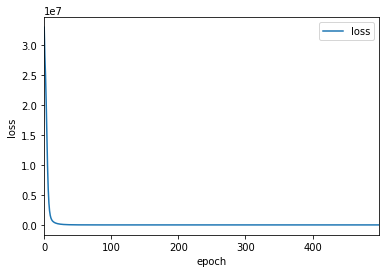

In [33]:
import torch
import pandas as pd

loss_df = pd.DataFrame(index=list(range(500)), columns=["loss"])

device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda') # Uncomment this to run on GPU

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random input and output data as tensors
# directly on the currente device
x =  torch.randn(N, D_in, device=device) # [BLANK]
y = torch.randn(N, D_out, device=device) # [BLANK]

# Randomly initialize weights as tensors
w1 = torch.randn(D_in, H, device=device)  # [BLANK]
w2 = torch.randn(H, D_out, device=device) # [BLANK]

learning_rate = 1e-6
for epoch in range(500):
    # Forward pass: compute predicted y
    h = x.mm(w1)
    h_relu = h.clamp(min=0)
    y_pred = h_relu.mm(w2)

    # Compute and store loss; loss is a scalar, and is stored in a PyTorch Tensor
    # of shape (); we can get its value as a Python number with loss.item().
    loss = (y_pred - y).pow(2).sum()
    loss_df.at[epoch, "loss"] = loss.item()

    # Backprop to compute gradients of w1 and w2 with respect to loss
    grad_y_pred = 2.0 * (y_pred - y)
    grad_w2 = h_relu.t().mm(grad_y_pred)
    grad_h_relu = grad_y_pred.mm(w2.t())
    grad_h = grad_h_relu.clone()
    grad_h[h < 0] = 0
    grad_w1 = x.t().mm(grad_h)

    # Update weights using gradient descent
    w1 -= learning_rate * grad_w1  # [BLANK]
    w2 -= learning_rate * grad_w2  # [BLANK]

# print first three and last three values of the loss
print(loss_df.iloc[[1,2,3, -3,-2,-1]])

xs = loss_df.plot()
_ = xs.set_ylabel("loss")
_ = xs.set_xlabel("epoch")

## 3) PyTorch: Autograd
<a name="3"></a>
[back to Outline](#outline)

In the above examples, we had to manually implement both the forward and backward passes of our neural network. Manually implementing the backward pass is not a big deal for a small two-layer network, but can quickly get very hairy for large complex networks.

Thankfully, we can use **automatic differentiation** to automate the computation of backward passes in neural networks.

The **autograd** package in PyTorch provides exactly this functionality. When using autograd, the forward pass of your network will define a **computational graph**.

Nodes in the graph will be Tensors, and edges will be functions that produce output Tensors from input Tensors. Backpropagating through this graph then allows you to easily compute gradients.

This sounds complicated, it's pretty simple to use in practice. If we want to compute gradients with respect to some Tensor, then we set `requires_grad=True` when constructing that Tensor.

Any PyTorch operations on that Tensor will cause a computational graph to be constructed, allowing us to later perform backpropagation through the graph. If `x` is a Tensor with `requires_grad=True`, then after backpropagation `x.grad` will be another Tensor holding the gradient of `x` with respect to some scalar value.

### requires_grad and gradients

Let's create a tensor and set `requires_grad=True` to track computation with it

In [15]:
x = torch.ones(1, 1, requires_grad=True)
print(x)

tensor([[1.]], requires_grad=True)


Let's do a tensor operation

In [16]:
y = x + 2
print(y)

tensor([[3.]], grad_fn=<AddBackward0>)


`y` was created as a result of an operation on a tensor which "required grad". So it has a `grad_fn`, and it requires grad too.

In [17]:
print(y.grad_fn)
print(y.requires_grad)

True


In [18]:
out = y ** 3
print(out)

tensor([[27.]], grad_fn=<PowBackward0>)


Let’s backprop now using `out.backward()` and check the gradients of the first input `x`.

In [19]:
out.backward()
print(x.grad)

tensor([[27.]])


If we were to calculate the gradients by hand, we would have:

$out = (x+2)^3$

$\frac{\partial out}{\partial x} = 3(x+2)^2$

$\frac{\partial out}{\partial x}\bigr\rvert_{x=1} = 3(1+2)^2 = 27$

### Resetting the gradient

Pay attention to the fact that **gradientes are not reset automatically** in pytorch, but they keep adding up.
This is useful in some architectures.

Notice the difference in the following three cases.

In [20]:
x = torch.tensor([2.], requires_grad=True)
print(x)

for i in range(3):
    y = x**2
    y.backward()
    print(x.grad.item(), f"gradient of x after {i+1} operation(s)")
print("-------------")
print("value of y.")
print(y.item())
print("gradient of x^2 accumulated 3 times.")
print(x.grad.item())

tensor([2.], requires_grad=True)
4.0 gradient of x after 1 operation(s)
8.0 gradient of x after 2 operation(s)
12.0 gradient of x after 3 operation(s)
-------------
value of y.
4.0
gradient of x^2 accumulated 3 times.
12.0


In [21]:
x = torch.tensor([2.], requires_grad=True)
print(x)

for i in range(3):
    y = x**2
y.backward()
print("-------------")
print("value of y.")
print(y.item())
print("gradient of x^2.")
print(x.grad.item())

tensor([2.], requires_grad=True)
-------------
value of y.
4.0
gradient of x^2.
4.0


In [22]:
x = torch.tensor([2.], requires_grad=True)
print(x)

for i in range(3):
    if x.grad:  # manually zeroing the gradient
        x.grad.zero_()
    y = x**2
    y.backward()
    print(x.grad.item(), f"gradient of x after {i+1} operation(s)")
    
print("-------------")
print("value of y.")
print(y.item())
print("gradient of x^2.")
print(x.grad.item())

tensor([2.], requires_grad=True)
4.0 gradient of x after 1 operation(s)
4.0 gradient of x after 2 operation(s)
4.0 gradient of x after 3 operation(s)
-------------
value of y.
4.0
gradient of x^2.
4.0


### Stop tracking the gradients

Sometimes you may wish to _prevent PyTorch from building computational graphs_ when performing certain operations on Tensors with `requires_grad=True`. For example we usually don't want to backpropagate through the weight update steps when **testing** a neural network.

In such scenarios we can use the `torch.no_grad()` context manager to prevent the construction of a computational graph.

Or use `.detach()` to get a new Tensor with the same content but that does not require gradients:

In [23]:
x = torch.ones(2,2,requires_grad=True)
print(x.requires_grad)
print((x ** 2).requires_grad)

with torch.no_grad():
    print((x ** 2).requires_grad)

True
True
False


In [24]:
x = torch.ones(2,2,requires_grad=True)
print(x.requires_grad)
y = x.detach()
print(y.requires_grad)
print(x.eq(y).all())

True
False
tensor(True)


### Let's make the point

This means that the lines of code that we previously used to manually compute the gradients...

```python
...
    loss = [CODE TO CALCULATE LOSS]

    # Backprop to compute gradients of w1 and w2 with respect to loss
    grad_y_pred = 2.0 * (y_pred - y)
    grad_w2 = h_relu.t().mm(grad_y_pred)
    grad_h_relu = grad_y_pred.mm(w2.t())
    grad_h = grad_h_relu.clone()
    grad_h[h < 0] = 0
    grad_w1 = x.t().mm(grad_h)
...
```

... are no longer required, as the gradients are computed automatically by autograd and stored in the tensors themselves.

We just need to **reset the gradients first, and then call the `.backward()` function** at each epoch.

```python
...
    loss = [CODE TO CALCULATE LOSS]
    
    model.zero_grad()
    loss.backward()
...
```

## 4) PyTorch: nn
<a name="4"></a>
[back to Outline](#outline)

Computational graphs and autograd are a very powerful paradigm for defining complex operators and automatically taking derivatives; however for large neural networks raw autograd can be a bit too low-level.

When building neural networks we frequently think of arranging the computation into **layers**, some of which have **learnable parameters** which will be **optimized** during learning.

In PyTorch, the **`nn` package** defines a set of Modules, which are roughly equivalent to neural network layers.
A Module receives input Tensors and computes output Tensors, but may also hold internal state such as Tensors containing learnable parameters.

The `nn` package also defines a set of useful **loss functions** that are commonly used when training neural networks.

### A Sequential model

The modules we need to create the same neural network as before are:

- `torch.nn.Linear(input_size, hidden_size)` (used twice)
- `torch.nn.ReLu()`

Layers can be concatenated to create a sequential model with little to no effort using

`model = torch.nn.Sequential(layer_1, layer_2, ..., layer_n)`

The loss function we used up until can be created using:

- `torch.nn.MSELoss(reduction='sum')`

Try and create:

- a simple sequential model with the same architecture as the previous ones
- a loss function as suggested in the explanation above
- use the model to get predictions for an input `x` (a `N x D_in` matrix of ones)
- use the loss function to compute the differenct between `preds` and `y` (loss functions take two arguments, in this order)

Compare your results with the expected output below.

In [25]:
import torch
import torch.nn as nn
import numpy as np
import random

# fix random seed for reproducibility (hopefully)
torch.manual_seed(123)
torch.cuda.manual_seed(123)
np.random.seed(123)
random.seed(123)

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N = 10 
D_in = 1000
H = 100
D_out = 5

# Create Tensors of ONES to hold inputs and outputs
x = torch.ones(N, D_in)
y = torch.ones(N, D_out)

# Create a Sequential model with the same architecture
# as the previous ones (see image at the beginning of the notebook)
# Move it to the current device using .to(device)
# as you would to with a Tensor
model = torch.nn.Sequential(
        nn.Linear(D_in,H), 
        nn.ReLU(), 
        nn.Linear(H,D_out)).to(device)  # [BLANK]

# Create the loss function
loss_fn = torch.nn.MSELoss(reduction='sum')  # [BLANK]
# Get the predictions from the model:
# just use it as a function, passing x as the input
preds = model(x)  # [BLANK]
# Calculate the loss
loss = loss_fn(preds, y)  # [BLANK]

print(model)
print(loss_fn)
print(preds)
print(loss)

Sequential(
  (0): Linear(in_features=1000, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=5, bias=True)
)
MSELoss()
tensor([[ 0.1848,  0.1407,  0.0075, -0.5831,  0.3746],
        [ 0.1848,  0.1407,  0.0075, -0.5831,  0.3746],
        [ 0.1848,  0.1407,  0.0075, -0.5831,  0.3746],
        [ 0.1848,  0.1407,  0.0075, -0.5831,  0.3746],
        [ 0.1848,  0.1407,  0.0075, -0.5831,  0.3746],
        [ 0.1848,  0.1407,  0.0075, -0.5831,  0.3746],
        [ 0.1848,  0.1407,  0.0075, -0.5831,  0.3746],
        [ 0.1848,  0.1407,  0.0075, -0.5831,  0.3746],
        [ 0.1848,  0.1407,  0.0075, -0.5831,  0.3746],
        [ 0.1848,  0.1407,  0.0075, -0.5831,  0.3746]],
       grad_fn=<AddmmBackward>)
tensor(52.8523, grad_fn=<MseLossBackward>)


**Expected output:**

```python
Sequential(
  (0): Linear(in_features=1000, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=5, bias=True)
)
MSELoss()
tensor([[ 0.1848,  0.1407,  0.0075, -0.5831,  0.3746],
        [ 0.1848,  0.1407,  0.0075, -0.5831,  0.3746],
        [ 0.1848,  0.1407,  0.0075, -0.5831,  0.3746],
        [ 0.1848,  0.1407,  0.0075, -0.5831,  0.3746],
        [ 0.1848,  0.1407,  0.0075, -0.5831,  0.3746],
        [ 0.1848,  0.1407,  0.0075, -0.5831,  0.3746],
        [ 0.1848,  0.1407,  0.0075, -0.5831,  0.3746],
        [ 0.1848,  0.1407,  0.0075, -0.5831,  0.3746],
        [ 0.1848,  0.1407,  0.0075, -0.5831,  0.3746],
        [ 0.1848,  0.1407,  0.0075, -0.5831,  0.3746]],
       grad_fn=<AddmmBackward>)
tensor(52.8523, grad_fn=<MseLossBackward>)
```

## 5) PyTorch: optim
<a name="5"></a>
[back to Outline](#outline)

Up to this point we have updated the weights of our models by manually mutating Tensors holding learnable parameters. This is not a huge burden for simple optimization algorithms like stochastic gradient descent, but in practice we often train neural networks using more sophisiticated optimizers like AdaGrad, RMSProp, Adam, etc.

The **`optim` package** in PyTorch abstracts the idea of an optimization algorithm and provides implementations of commonly used optimization algorithms.

In this example we will use the `nn` package to define our model as before, but we will optimize the model using the Adam algorithm provided by the `optim` package:

          loss
1      199.422
2       177.67
3      157.561
497  0.0633041
498  0.0621613
499  0.0610339


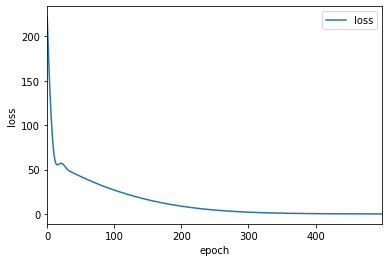

In [26]:
import torch
import torch.nn as nn
import pandas as pd

loss_df = pd.DataFrame(index=list(range(500)), columns=["loss"])

device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda') # Uncomment this to run on GPU

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create RANDOM Tensors to hold inputs and outputs.
x = torch.rand(N, D_in)  # [BLANK]
y = torch.rand(N, D_out)  # [BLANK]

# Use the nn package to define our model (Sequential) and loss function
model = model = torch.nn.Sequential(
        nn.Linear(D_in,H), 
        nn.ReLU(), 
        nn.Linear(H,D_out)).to(device)
loss_fn = torch.nn.MSELoss(reduction='sum')  # [BLANK]


# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use Adam; the optim package contains many other
# optimization algorithms. The first argument to the Adam constructor tells the
# optimizer which Tensors it should update.
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


for epoch in range(500):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x)  # [BLANK]

    # Compute and print loss.
    loss = loss_fn(y_pred, y)  # [BLANK]
    loss_df.at[epoch, "loss"] = loss.item()

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the Tensors it will update (which are the learnable weights
    # of the model)
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()  # [BLANK]

    # Calling the step function on an Optimizer makes an update to its parameters
    optimizer.step()
    
# print first three and last three values of the loss
print(loss_df.iloc[[1,2,3, -3,-2,-1]])

xs = loss_df.plot()
_ = xs.set_ylabel("loss")
_ = xs.set_xlabel("epoch")

## 6) Custom nn Modules
<a name="6"></a>
[back to Outline](#outline)

Sometimes you will want to specify models that are more **complex than a sequence of existing Modules**; for these cases you can define your own Modules by subclassing `nn.Module` and defining a `forward` which receives input Tensors and produces output Tensors using other modules or other autograd operations on Tensors.

In this example we implement our two-layer network as a custom Module subclass:

In [27]:
import torch
import torch.nn as nn
import pandas as pd

class TwoLayerNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(TwoLayerNet, self).__init__()
        self.linear1 = nn.Linear(D_in, H)  # [BLANK]
        self.linear2 = nn.Linear(H, D_out)  # [BLANK]
        self.relu = nn.ReLU()  # [BLANK]

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary (differentiable) operations on Tensors.
        """
        hidden1 = self.linear1(x)
        h_relu  = self.relu(hidden1)  # [BLANK]
        y_pred  = self.linear2(h_relu)  # [BLANK]
        return y_pred

# Construct our model by instantiating the class defined above.
model = TwoLayerNet(D_in, H, D_out)
model

TwoLayerNet(
  (linear1): Linear(in_features=1000, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=10, bias=True)
  (relu): ReLU()
)

**Expected output:**

```python
TwoLayerNet(
  (linear1): Linear(in_features=1000, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=10, bias=True)
  (relu): ReLU()
)
```



            loss
1        643.004
2        597.683
3        558.595
497  5.87379e-06
498  5.70722e-06
499  5.54507e-06


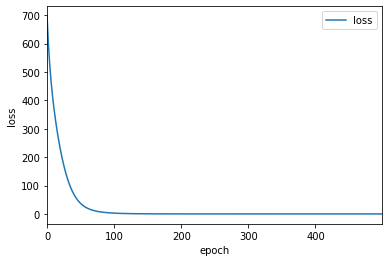

In [28]:
loss_df = pd.DataFrame(index=list(range(500)), columns=["loss"])

device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda') # Uncomment this to run on GPU
    
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# Construct our loss function and an Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters of the two
# nn.Linear modules which are members of the model.
learning_rate = 1e-4
loss_fn = torch.nn.MSELoss(reduction='sum')  # [BLANK]
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)   # use the optim.SGD optimizer this time!

for epoch in range(500):

    y_pred = model(x)  # [BLANK]  # Forward pass: Compute predicted y by passing x to the model
    loss = loss_fn(y_pred, y)  # [BLANK]    # Compute and print loss
    
    loss_df.at[epoch, "loss"] = loss.item()

    optimizer.zero_grad()  # [BLANK]  # Zero gradients, 
    loss.backward()  # [BLANK]  # perform a backward pass,
    optimizer.step()  # [BLANK]  # and update the weights.
    

print(loss_df.iloc[[1,2,3, -3,-2,-1]])
xs = loss_df.plot()
_ = xs.set_ylabel("loss")
_ = xs.set_xlabel("epoch")

## 7) Control Flow + Weight Sharing [Exercise]
<a name="7"></a>
[back to Outline](#outline)

As an example of dynamic graphs and weight sharing, we implement a very strange model: a fully-connected ReLU network that on each forward pass chooses a random number between 1 and 4... and uses that many hidden layers! The hidden layers reuse the same weights multiple times to compute the innermost hidden representation.

For this model you can use normal Python `for` loop and you can implement weight sharing among the innermost layers by simply reusing the same Module multiple times when defining the `forward` pass.

Try it for yourself!

**Scheme for the Architecture**

It only needs 4 modules:
- an `input_linear` layer to generate the first hidden representation
- a `middle_linear` layer (which will be reused)
- an `output_linear` layer to output the final prediction
- a `relu` layer for all the needed activations

```python
                   INPUT (x)
                 [ N x D_in ]
        +--------------------------+
         \      Linear Layer      /
          \    "input_linear"    /
           +-----[ N x H ]------+
           |       ReLu         |
           +--------------------+
                 [ N x H ]
       . . . . . . . . . . . . . . . .
       .   +--------------------+    . this block is
       .   |    Linear Layer    |    . randomly repeated
       .   |   "middle_linear"  |    . from 0 to 3 times
       .   +-----[ N x H ]------+    . to generate
       .   |       ReLu         |    . from 1 to 4
       .   +--------------------+    . hidden layers
       . . . . . . . . . . . . . . . .
                 [ N x H ]
           +--------------------+    
          /     Linear Layer     \   
         /     "ouput_linear"     \      
        +--------------------------+ 
               [ N x D_out ]      
             PREDICTION (y_pred)  

```


In [29]:
import random
import torch
import torch.nn as nn
import pandas as pd

class DynamicNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(DynamicNet,self).__init__() 
        
        self.layers = nn.Sequential( 
            nn.Linear(D_in,H), 
            nn.ReLU(), 
            nn.Linear(H,D_out))

    def forward(self, x):
        y_pred = self.layers(x)  # [BLANK]
        return y_pred


            loss
1        632.766
2        550.182
3        459.166
497  2.47315e-12
498  2.36447e-12
499  2.40911e-12


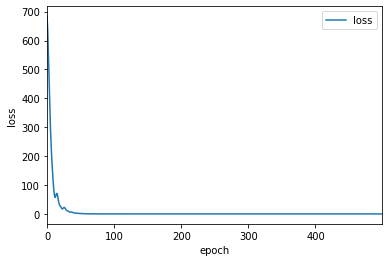

In [30]:
loss_df = pd.DataFrame(index=list(range(500)), columns=["loss"])

device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda') # Uncomment this to run on GPU
    
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold inputs and outputs.
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# Construct our model by instantiating the class defined above
model = DynamicNet(D_in, H, D_out)  # [BLANK]

# Construct our loss function and an Optimizer. Training this strange model with
# vanilla stochastic gradient descent is tough, so we use momentum
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)

for epoch in range(500): # train your model!
    y_pred = model(x)  # [BLANK]  # Forward pass: Compute predicted y by passing x to the model
    loss = loss_fn(y_pred, y)  # [BLANK]    # Compute and print loss
    loss_df.at[epoch, "loss"] = loss.item()

    optimizer.zero_grad()  # [BLANK]  # Zero gradients, 
    loss.backward()  # [BLANK]  # perform a backward pass,
    optimizer.step()  # [BLANK]

# print first three and last three values of the loss
print(loss_df.iloc[[1,2,3, -3,-2,-1]])

xs = loss_df.plot()
_ = xs.set_ylabel("loss")
_ = xs.set_xlabel("epoch")